In [1]:
%matplotlib inline

import time
import datetime as dt
from math import sqrt, pi

import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import interp1d

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr

import fix_yahoo_finance as yf

In [2]:
# Underlying price
S = 45.0

# Range of underlying prices for payoff profile
S_ = np.arange(40.0, 50.0, 0.01)

# Strike price
K = 45.0

# Time to exp
t = 164.0/365.0

r = 0.02

vol = 0.25

In [3]:
call_payoff = lambda S, K: np.maximum(S_ - K, 0.0)
put_payoff = lambda S, K: np.maximum(K - S_, 0.0)

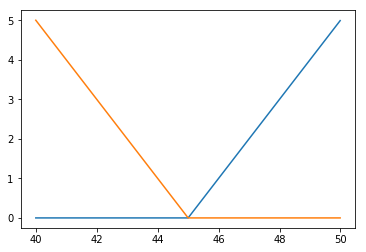

In [4]:
plt.figure(1)
plt.plot(S_, call_payoff(S_, K))
plt.plot(S_, put_payoff(S_, K))

In [5]:
def N(z):
    return norm.cdf(z)

def bs_call_val(S, K, r, t, vol):
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    return N(d1) * S - N(d2) * K * np.exp(-r * t)

def bs_put_val(S, K, r, t, vol):
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    return N(-d2) * K * np.exp(-r * t) - N(-d1) * S

In [6]:
print('BS Call Value: %0.2f' % bs_call_val(S, K, r, t, vol))
print('BS Put Value: %0.2f' % bs_put_val(S, K, r, t, vol))

BS Call Value: 3.20
BS Put Value: 2.79


In [7]:
# get the value of the option with six months to expiration
black_scholes_call_value_six_months = bs_call_val(S_, K, r, 0.5, vol)

# get the value of the option with three months to expiration
black_scholes_call_value_three_months = bs_call_val(S_, K, r, 0.25, vol)

# get the value of the option with one month to expiration
black_scholes_call_value_one_month = bs_call_val(S_, K, r, 1.0/12.0, vol)

# get payoff value at expiration
call_payoff_at_expiration = call_payoff(S_, K)

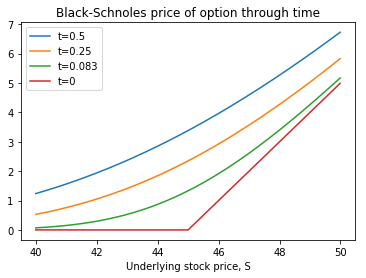

In [8]:
# plot the call payoffs
plt.figure(3)
plt.plot(S_, black_scholes_call_value_six_months)
plt.plot(S_, black_scholes_call_value_three_months)
plt.plot(S_, black_scholes_call_value_one_month)
plt.plot(S_, call_payoff_at_expiration)
plt.title('Black-Schnoles price of option through time')
plt.xlabel('Underlying stock price, S')
plt.legend(['t=0.5', 't=0.25', 't=0.083', 't=0'], loc=2)

In [9]:
def phi(x):
    """ Phi helper function
    
    """
    return np.exp(-0.5 * x * x) / (sqrt(2.0 * pi))

def call_delta(S, K, r, t, vol):
    """ Black-Scholes call delta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call delta
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    
    return N(d1)

def put_delta(S, K, r, t, vol):
    """ Black-Scholes put delta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put delta
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    
    return N(d1) - 1.0

def gamma(S, K, r, t, vol):
    """ Black-Scholes gamma
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: gamma
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    
    return phi(d1) / (S * vol * sqrt(t))

def vega(S, K, r, t, vol):
    """ Black-Scholes vega
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: vega
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    
    return (S * phi(d1) * sqrt(t)) / 100.0

def call_theta(S, K, r, t, vol):
    """ Black-Scholes call theta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call theta
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    theta = -((S * phi(d1) * vol) / (2.0 * np.sqrt(t))) - (r * K * np.exp(-r * t) * N(d2))
    return theta / 365.0

def put_theta(S, K, r, t, vol):
    """ Black-Scholes put theta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put theta
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    theta = -((S * phi(d1) * vol) / (2.0 * np.sqrt(t))) + (r * K * np.exp(-r * t) * N(-d2))
    return theta / 365.0

def call_rho(S, K, r, t, vol):
    """ Black-Scholes call rho
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call rho
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    rho = K * t * np.exp(-r * t) * N(d2)
    return rho / 100.0

def put_rho(S, K, r, t, vol):
    """ Black-Scholes put rho
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put rho
    """
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol**2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))
    
    rho = -K * t * np.exp(-r * t) * N(-d2)
    return rho / 100.0

In [10]:
# print each of the results
print('Black-Scholes call delta %0.4f' % call_delta(S, K, r, t, vol))
print('Black-Scholes put delta %0.4f' % put_delta(S, K, r, t, vol))
print('Black-Scholes gamma %0.4f' % gamma(S, K, r, t, vol))
print('Black-Scholes vega %0.4f' % vega(S, K, r, t, vol))
print('Black-Scholes call theta %0.4f' % call_theta(S, K, r, t, vol))
print('Black-Scholes put theta %0.4f' % put_theta(S, K, r, t, vol))
print('Black-Scholes call rho %0.4f' % call_rho(S, K, r, t, vol))
print('Black-Scholes put rho %0.4f' % put_rho(S, K, r, t, vol))

Black-Scholes call delta 0.5546
Black-Scholes put delta -0.4454
Black-Scholes gamma 0.0524
Black-Scholes vega 0.1192
Black-Scholes call theta -0.0103
Black-Scholes put theta -0.0078
Black-Scholes call rho 0.0978
Black-Scholes put rho -0.1026


In [11]:
def call_implied_volatility_objective_function(S, K, r, t, vol, call_option_market_price):
    """ Objective function which sets market and model prices to zero
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :param call_option_market_price: market observed option price
    :return: error between market and model price
    """
    return call_option_market_price - bs_call_val(S, K, r, t, vol)

def call_implied_volatility(S, K, r, t, call_option_market_price, a=-2.0, b=2.0, xtol=1e-6):
    """ Call implied volatility function
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param call_option_market_price: market observed option price
    :param a: lower bound for brentq method
    :param b: upper gound for brentq method
    :param xtol: tolerance which is considered good enough
    :return: volatility to sets the difference between market and model price to zero
    
    """
    # avoid mirroring outer scope  
    _S, _K, _r, _t, _call_option_market_price = S, K, r, t, call_option_market_price
    
    # define a nested function that takes our target param as the input
    def fcn(vol):
        
        # returns the difference between market and model price at given volatility
        return call_implied_volatility_objective_function(_S, _K, _r, _t, vol, _call_option_market_price)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(fcn, a=a, b=b, xtol=xtol)
        
        # if the results are *too* small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    # if it fails then we return np.nan so we can later interpolate the results
    except ValueError:
        return np.nan

def put_implied_volatility_objective_function(S, K, r, t, vol, put_option_market_price):
    """ Objective function which sets market and model prices to zero
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :param call_option_market_price: market observed option price
    :return: error between market and model price
    """
    return put_option_market_price - bs_put_val(S, K, r, t, vol)

def put_implied_volatility(S, K, r, t, put_option_market_price, a=-2.0, b=2.0, xtol=1e-6):
    """ Put implied volatility function
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param call_option_market_price: market observed option price
    :param a: lower bound for brentq method
    :param b: upper gound for brentq method
    :param xtol: tolerance which is considered good enough
    :return: volatility to sets the difference between market and model price to zero
    
    """
    
    # avoid mirroring out scope  
    _S, _K, _r, _t, _put_option_market_price = S, K, r, t, put_option_market_price
    
    # define a nsted function that takes our target param as the input
    def fcn(vol):
        
        # returns the difference between market and model price at given volatility
        return put_implied_volatility_objective_function(_S, _K, _r, _t, vol, _put_option_market_price)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(fcn, a=a, b=b, xtol=xtol)
        
        # if the results are *too* small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    # if it fails then we return np.nan so we can later interpolate the results
    except ValueError:
        return np.nan

In [12]:
# get the call and put values to test the implied volatility output
call_model_price = bs_call_val(S, K, r, t, vol)
print('Call implied volatility if market and model were equal (should be close to 0.25) %0.6f' % call_implied_volatility(S, K, r, t, call_model_price))

put_model_price = bs_put_val(S, K, r, t, vol)
print('Put implied volatility if market and model were equal (should be close to 0.25) %0.6f' % put_implied_volatility(S, K, r, t, put_model_price))

Call implied volatility if market and model were equal (should be close to 0.25) 0.250000
Put implied volatility if market and model were equal (should be close to 0.25) 0.250000


In [13]:
# Real data here
underlying_symbol = 'IBM'

options_obj = pd.Options('IBM', 'yahoo')

AttributeError: module 'pandas' has no attribute 'Options'